<a href="https://colab.research.google.com/github/aborbala/tree-canopy/blob/main/02_01_Inner_tile_cropping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Inner Tile Cropping and YOLO Annotation Generation **EXPERIMENTAL**

Crops overlapping tile regions and converts polygon annotations to YOLO instance 
segmentation format for object detection training.

Overview:
    Detects spatial neighbors between tiles, crops inner regions to remove overlaps,
    and converts annotations to YOLO format with normalized coordinates.

Main Sections:

    1. Configuration - Set input/output directories and load tile metadata
    2. Spatial Neighbor Detection - Identify top/bottom/left/right neighbors
    3. Inner Tile Cropping - Remove 10m margins based on neighbor position
    4. Annotation Processing - Filter and crop polygons to inner regions
    5. YOLO Format Conversion - Normalize coordinates with Y-axis flipping
    6. Optional Masking - Remove partial objects extending beyond tile bounds
    7. Visualization - Display original/cropped boundaries and annotations

Key Data:

    Input:
    - Sliced DOP tiles (100m x 100m, overlapping)
    - Tile metadata (GeoJSON with bounding boxes)
    - Crown annotations (GeoJSON polygons per tile)
    
    Output:
    - Cropped inner tile images (non-overlapping)
    - YOLO annotations (.txt format)

CRS: EPSG:25833 (UTM Zone 33N)

Processing Parameters:

    - Margin removal: 10 meters per side
    - Image resolution: 0.20 meters per pixel
    - YOLO format: class_id + normalized polygon vertices [0, 1]

Output Locations:

    - {aoi_code}/inner_tiles/ - Cropped images
    - {aoi_code}/inner_annotations_veg_mask/ - YOLO annotation files
    - {aoi_code}/masked_tiles/ - Optional masked images

Key Features:

    - Spatial neighbor detection via intersection tests
    - Dynamic margin calculation per tile
    - Polygon cropping and coordinate normalization
    - Y-axis flipping for YOLO format
    - Optional masking of partial objects

Workflow:

    1. Load tile metadata and identify neighbors
    2. For each tile: detect neighbors → crop image → filter annotations → convert to YOLO
    3. (Optional) Mask partial objects from neighboring tiles
    4. Visualize results for validation
"""

# --- Setup ---

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!pip install geopandas rasterio shapely

In [ ]:
import os
import geopandas as gpd
import rasterio
import numpy as np
from shapely.geometry import box, Polygon

In [ ]:
# --- Configuration ---

In [ ]:
tiles_dir = "/content/drive/MyDrive/masterthesis/data/386_5818/"
geojson_dir = "/content/drive/MyDrive/masterthesis/data/386_5818/crowns_clean_veg_mask/"
image_dir = "/content/drive/MyDrive/masterthesis/data/386_5818/sliced_imgs_2020S/"
output_image_dir = "/content/drive/MyDrive/masterthesis/data/386_5818/inner_tiles/"
output_annotation_dir = "/content/drive/MyDrive/masterthesis/data/386_5818/inner_annotations_veg_mask/"

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_annotation_dir, exist_ok=True)

tiles_gdf = gpd.read_file(os.path.join(tiles_dir, "tiles.geojson"))
tiles_gdf.set_index("tile_name", inplace=True)  # Index by tile_name

useMasking = False


# --- Functions ---

In [24]:
def has_spatial_neighbor(tiles_gdf, tile_geom):
    """
    Checks if a tile has neighbors using spatial intersection (instead of bounding box matching).

    Args:
        tiles_gdf (GeoDataFrame): Tile bounding boxes (overlapping image slices).
        tile_geom (Polygon): The current tile geometry.

    Returns:
        Tuple (has_top, has_bottom, has_left, has_right)
    """
    neighbors = tiles_gdf[tiles_gdf.geometry.intersects(tile_geom) & (tiles_gdf.geometry != tile_geom)]

    # Get bounds for the current tile
    minx, miny, maxx, maxy = tile_geom.bounds

    # If a tile intersects with another, it has neighbors
    has_top = any(neighbors.bounds["maxy"] > maxy)
    has_bottom = any(neighbors.bounds["miny"] < miny)
    has_left = any(neighbors.bounds["maxx"] > maxx)
    has_right = any(neighbors.bounds["minx"] < minx)

    return has_top, has_bottom, has_left, has_right


In [ ]:
def crop_inner_tile(tile_name, image_path, output_path, tiles_gdf, margin_m=10, resolution=0.20):
    """
    Crops the inner region of an image tile based on overlap and saves it.

    Args:
        tile_name (str): Name of the tile.
        image_path (str): Path to original tile image.
        output_path (str): Path to save cropped inner tile.
        tiles_gdf (GeoDataFrame): Tile bounding boxes.
        margin_m (int): Overlap to remove in meters (default=35m).
        resolution (float): Resolution of the DOP image in meters per pixel (default=0.20m/pixel).
    """
    with rasterio.open(image_path) as src:
        transform = src.transform
        tile_geom = tiles_gdf.loc[tile_name].geometry
        minx, miny, maxx, maxy = tile_geom.bounds

        # **Check for neighbors using spatial intersection**
        has_top, has_bottom, has_left, has_right = has_spatial_neighbor(tiles_gdf, tile_geom)

        # **Convert margin from meters to pixels**
        margin_px = int(margin_m / resolution)  # Convert 35m to pixels (175 pixels at 0.20m resolution)

        # **Calculate inner tile boundaries (in pixels)**
        row_min = max(0, 0 + (margin_px if has_top else 0))  # Prevent negative values
        col_min = max(0, 0 + (margin_px if has_left else 0))
        row_max = min(src.height, src.height - (margin_px if has_bottom else 0))  # Prevent values exceeding image size
        col_max = min(src.width, src.width - (margin_px if has_right else 0))

        # **Debug Output**
        print(f"\n📌 Debugging Tile: {tile_name}")
        print(f"  ➤ Has Top: {has_top}, Has Bottom: {has_bottom}, Has Left: {has_left}, Has Right: {has_right}")
        print(f"  ➤ Original Size: {src.width} x {src.height} pixels")
        print(f"  ➤ Cropped Size: {col_max - col_min} x {row_max - row_min} pixels")

        # **Check if cropping is valid**
        if (col_max - col_min) <= 0 or (row_max - row_min) <= 0:
            print(f"⚠️ WARNING: Tile {tile_name} is too small after cropping! Skipping.")
            return  # Skip saving this tile if it results in invalid dimensions

        # **Crop image**
        cropped_image = src.read(window=rasterio.windows.Window(col_min, row_min, col_max - col_min, row_max - row_min))

        # **Update metadata**
        profile = src.profile
        profile.update({
            "height": row_max - row_min,
            "width": col_max - col_min,
            "transform": rasterio.windows.transform(
                rasterio.windows.Window(col_min, row_min, col_max - col_min, row_max - row_min),
                transform
            )
        })

        # **Save cropped image**
        with rasterio.open(output_path, "w", **profile) as dst:
            dst.write(cropped_image)

    print(f"✅ Cropped inner tile saved: {output_path}")

In [ ]:
def process_annotations_for_inner_tile(tile_name, annotation_path, output_txt_path, tiles_gdf, margin_m=10):
    """
    Filters and converts polygon annotations from GeoJSON to YOLO instance segmentation format.

    Args:
        tile_name (str): Tile name.
        annotation_path (str): Path to original annotation file (GeoJSON).
        output_txt_path (str): Path to save YOLO annotation file (.txt).
        tiles_gdf (GeoDataFrame): Tile bounding boxes.
        margin_m (int): Overlap to remove in meters.
    """
    gdf = gpd.read_file(annotation_path)

    # **Get inner bounding box**
    tile_geom = tiles_gdf.loc[tile_name].geometry
    minx, miny, maxx, maxy = tile_geom.bounds

    # **Check for neighbors using spatial intersection**
    has_top, has_bottom, has_left, has_right = has_spatial_neighbor(tiles_gdf, tile_geom)

    # **Apply the correct margin based on neighbor detection**
    x_inner_min = minx + (margin_m if has_left else 0)
    y_inner_min = miny + (margin_m if has_bottom else 0)
    x_inner_max = maxx - (margin_m if has_right else 0)
    y_inner_max = maxy - (margin_m if has_top else 0)

    inner_bbox = box(x_inner_min, y_inner_min, x_inner_max, y_inner_max)

    # **Filter polygons inside the correctly cropped inner tile**
    gdf = gdf[gdf.centroid.within(inner_bbox)]

    # **Convert to YOLO instance segmentation format**
    with open(output_txt_path, "w") as f:
        for _, row in gdf.iterrows():
            if isinstance(row.geometry, Polygon):
                polygon = np.array(row.geometry.exterior.coords)

                class_id = int(row["intersects_cadaster"])

                # **Normalize polygon coordinates and flip Y-axis correctly**
                flipped_normalized_polygon = [
                    ((x - x_inner_min) / (x_inner_max - x_inner_min),
                     1 - (y - y_inner_min) / (y_inner_max - y_inner_min))  # **Flip Y here**
                    for x, y in polygon
                ]

                # Ensure polygon is closed (add first point to the end)
                flipped_normalized_polygon.append(flipped_normalized_polygon[0])

                # Flatten coordinates for YOLO format
                # yolo_line = f"0 " + " ".join(f"{x:.6f} {y:.6f}" for x, y in flipped_normalized_polygon) + "\n"
                # f.write(yolo_line)
                pts = " ".join(f"{x:.6f} {y:.6f}" for x, y in flipped_normalized_polygon)
                f.write(f"{class_id} {pts}\n")

    print(f"✅ Saved YOLO segmentation annotation: {output_txt_path}")

# --- Processing ---

In [25]:
tile_name = list(tiles_gdf.index)[18]  # Test with first tile
image_path = os.path.join(image_dir, f"{tile_name}.tif")
output_path = os.path.join(output_image_dir, f"{tile_name}.tif")
tile_geom = tiles_gdf.loc[tile_name].geometry

In [ ]:
# Use spatial intersection
has_top, has_bottom, has_left, has_right = has_spatial_neighbor(tiles_gdf, tile_geom)

print(f"\n Debugging Tile: {tile_name}")
print(f"  ➤ Has Top: {has_top}, Has Bottom: {has_bottom}, Has Left: {has_left}, Has Right: {has_right}")


 Debugging Tile: 3dm_33_386_5818_1_be_nobuild_18
  ➤ Has Top: True, Has Bottom: True, Has Left: True, Has Right: True


In [29]:
for tile_name in tiles_gdf.index:
    image_path = os.path.join(image_dir, f"{tile_name}.tif")
    annotation_path = os.path.join(geojson_dir, f"{tile_name}.geojson")
    output_image_path = os.path.join(output_image_dir, f"{tile_name}.tif")
    output_annotation_path = os.path.join(output_annotation_dir, f"{tile_name}_inner.txt")
    print(image_path)
    # if os.path.exists(image_path):
    #     crop_inner_tile(tile_name, image_path, output_image_path, tiles_gdf)
    if os.path.exists(annotation_path):
        process_annotations_for_inner_tile(tile_name, annotation_path, output_annotation_path, tiles_gdf)


Streaming output truncated to the last 5000 lines.
✅ Saved YOLO segmentation annotation: /content/drive/MyDrive/masterthesis/data/386_5818/inner_annotations/3dm_33_386_5818_1_be_nobuild_50_inner.txt
/content/drive/MyDrive/masterthesis/data/386_5818/sliced_imgs_2020S/3dm_33_386_5818_1_be_nobuild_51.tif

📌 Debugging Tile: 3dm_33_386_5818_1_be_nobuild_51
  ➤ Has Top: True, Has Bottom: True, Has Left: True, Has Right: True
  ➤ Original Size: 200 x 500 pixels
  ➤ Cropped Size: 100 x 400 pixels
✅ Cropped inner tile saved: /content/drive/MyDrive/masterthesis/data/386_5818/inner_tiles/3dm_33_386_5818_1_be_nobuild_51.tif
✅ Saved YOLO segmentation annotation: /content/drive/MyDrive/masterthesis/data/386_5818/inner_annotations/3dm_33_386_5818_1_be_nobuild_51_inner.txt
/content/drive/MyDrive/masterthesis/data/386_5818/sliced_imgs_2020S/3dm_33_386_5818_1_be_nobuild_52.tif

📌 Debugging Tile: 3dm_33_386_5818_1_be_nobuild_52
  ➤ Has Top: True, Has Bottom: True, Has Left: True, Has Right: False
  ➤ Ori

# Experiment: Masking

In [ ]:
from rasterio.mask import mask

def mask_out_partial_objects(tile_name, image_path, output_path, annotation_path, tiles_gdf, margin_m=20):
    """
    Masks out partial objects in a tile that are not assigned to it.

    Args:
        tile_name (str): Name of the tile.
        image_path (str): Path to the original tile image.
        output_path (str): Path to save the masked image.
        annotation_path (str): Path to original annotation file.
        tiles_gdf (GeoDataFrame): Tile bounding boxes.
        margin_m (int): Overlap to remove in meters (default=20m).
    """
    with rasterio.open(image_path) as src:
        transform = src.transform
        tile_geom = tiles_gdf.loc[tile_name].geometry
        minx, miny, maxx, maxy = tile_geom.bounds

        # **Check for neighbors using spatial intersection**
        has_top, has_bottom, has_left, has_right = has_spatial_neighbor(tiles_gdf, tile_geom)

        # **Apply correct 10m per side margin**
        x_inner_min = minx + (margin_m / 2 if has_left else 0)
        y_inner_min = miny + (margin_m / 2 if has_bottom else 0)
        x_inner_max = maxx - (margin_m / 2 if has_right else 0)
        y_inner_max = maxy - (margin_m / 2 if has_top else 0)

        inner_bbox = box(x_inner_min, y_inner_min, x_inner_max, y_inner_max)

        # **Load annotations**
        gdf = gpd.read_file(annotation_path)

        # **Find objects that INTERSECT but are NOT ASSIGNED to this tile**
        partial_objects = gdf[~gdf.centroid.within(inner_bbox) & gdf.intersects(tile_geom)]

        # **Create mask polygon from these geometries**
        mask_polygons = [geom for geom in partial_objects.geometry if geom.is_valid]

        # **Apply the mask to the image**
        if mask_polygons:
            masked_image, masked_transform = mask(src, mask_polygons, invert=True, crop=False)
        else:
            masked_image = src.read()  # No mask needed

        # **Update metadata**
        profile = src.profile
        profile.update({
            "transform": masked_transform if mask_polygons else transform,
        })

        # **Save the masked image**
        with rasterio.open(output_path, "w", **profile) as dst:
            dst.write(masked_image)

    print(f"✅ Masked image saved: {output_path}")


In [31]:
# Define paths
inner_tiles_dir = "/content/drive/MyDrive/masterthesis/data/386_5818/inner_tiles/"
masked_tiles_dir = "/content/drive/MyDrive/masterthesis/data/386_5818/masked_tiles/"
annotations_dir = "/content/drive/MyDrive/masterthesis/data/386_5818/crowns_clean/"

# Create output directory if not exists
os.makedirs(masked_tiles_dir, exist_ok=True)

# Loop through all inner tiles
if (useMasking):
  for tile_name in tiles_gdf.index:
      image_path = os.path.join(inner_tiles_dir, f"{tile_name}_inner.tif")  # Inner tile image
      output_path = os.path.join(masked_tiles_dir, f"{tile_name}.tif")  # Masked output image
      annotation_path = os.path.join(annotations_dir, f"{tile_name}.geojson")  # Annotations

      # Check if image and annotation exist
      if os.path.exists(image_path) and os.path.exists(annotation_path):
          mask_out_partial_objects(tile_name, image_path, output_path, annotation_path, tiles_gdf)
      else:
          print(f"⚠️ Skipping {tile_name}, missing image or annotation file.")


# Create YOLO annotations

<ipython-input-32-c533e2eae04e>:57: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
<ipython-input-32-c533e2eae04e>:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


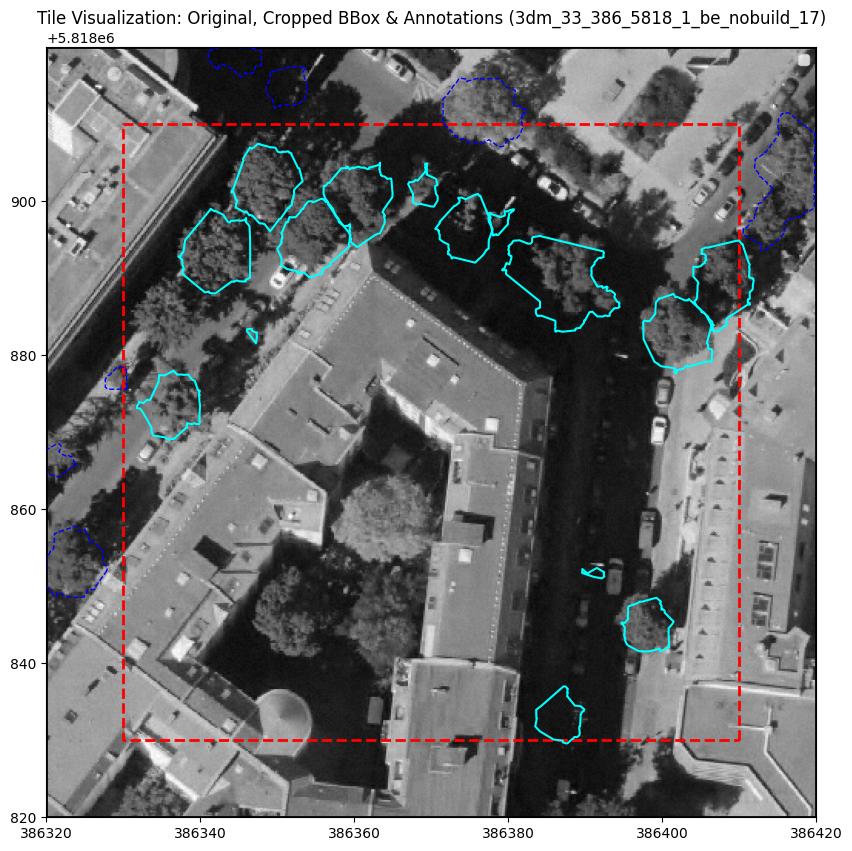

In [ ]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

# Test tile
example_tile_name = tiles_gdf.index[17]

tile_geom = tiles_gdf.loc[example_tile_name].geometry
minx, miny, maxx, maxy = tile_geom.bounds

# Check for neighbors using spatial intersection**
has_top, has_bottom, has_left, has_right = has_spatial_neighbor(tiles_gdf, tile_geom)

# Apply margin for cropping
margin_m = 10 
x_inner_min = minx + (margin_m if has_left else 0)
y_inner_min = miny + (margin_m if has_bottom else 0)
x_inner_max = maxx - (margin_m if has_right else 0)
y_inner_max = maxy - (margin_m if has_top else 0)
inner_geom = box(x_inner_min, y_inner_min, x_inner_max, y_inner_max)

image_path = os.path.join(image_dir, f"{example_tile_name}.tif")
annotation_path = os.path.join(annotations_dir, f"{example_tile_name}.geojson")

with rasterio.open(image_path) as src:
    image = src.read(1)

annotations_gdf = gpd.read_file(annotation_path)

# Filter annotations inside and outside the inner region
annotations_inner_gdf = annotations_gdf[annotations_gdf.centroid.within(inner_geom)]
annotations_outer_gdf = annotations_gdf[~annotations_gdf.centroid.within(inner_geom)]

# Plot the original image with overlays
fig, ax = plt.subplots(figsize=(10, 10))
show(image, transform=src.transform, cmap="gray", ax=ax)  # Show original image as background

# Plot Original tile boundary (Black)
gpd.GeoSeries(tile_geom).plot(ax=ax, edgecolor="black", facecolor="none", linewidth=2, label="Original Tile")

# Plot Inner tile boundary (Red, visibly smaller)
gpd.GeoSeries(inner_geom).plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2, linestyle="dashed", label="Inner Tile")

# Plot All annotations outside inner region (Blue dashed)
annotations_outer_gdf.plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=1, linestyle="--", label="Outer Annotations")

# Plot Annotations inside inner region (Cyan, correctly assigned)
annotations_inner_gdf.plot(ax=ax, edgecolor="cyan", facecolor="none", linewidth=1.5, label="Inner Annotations")

ax.set_title(f"Tile Visualization: Original, Cropped BBox & Annotations ({example_tile_name})")
ax.legend()
plt.show()

<ipython-input-33-02c28e0a768e>:63: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes[0].legend()
<ipython-input-33-02c28e0a768e>:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
<ipython-input-33-02c28e0a768e>:72: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes[1].legend()
<ipython-input-33-02c28e0a768e>:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


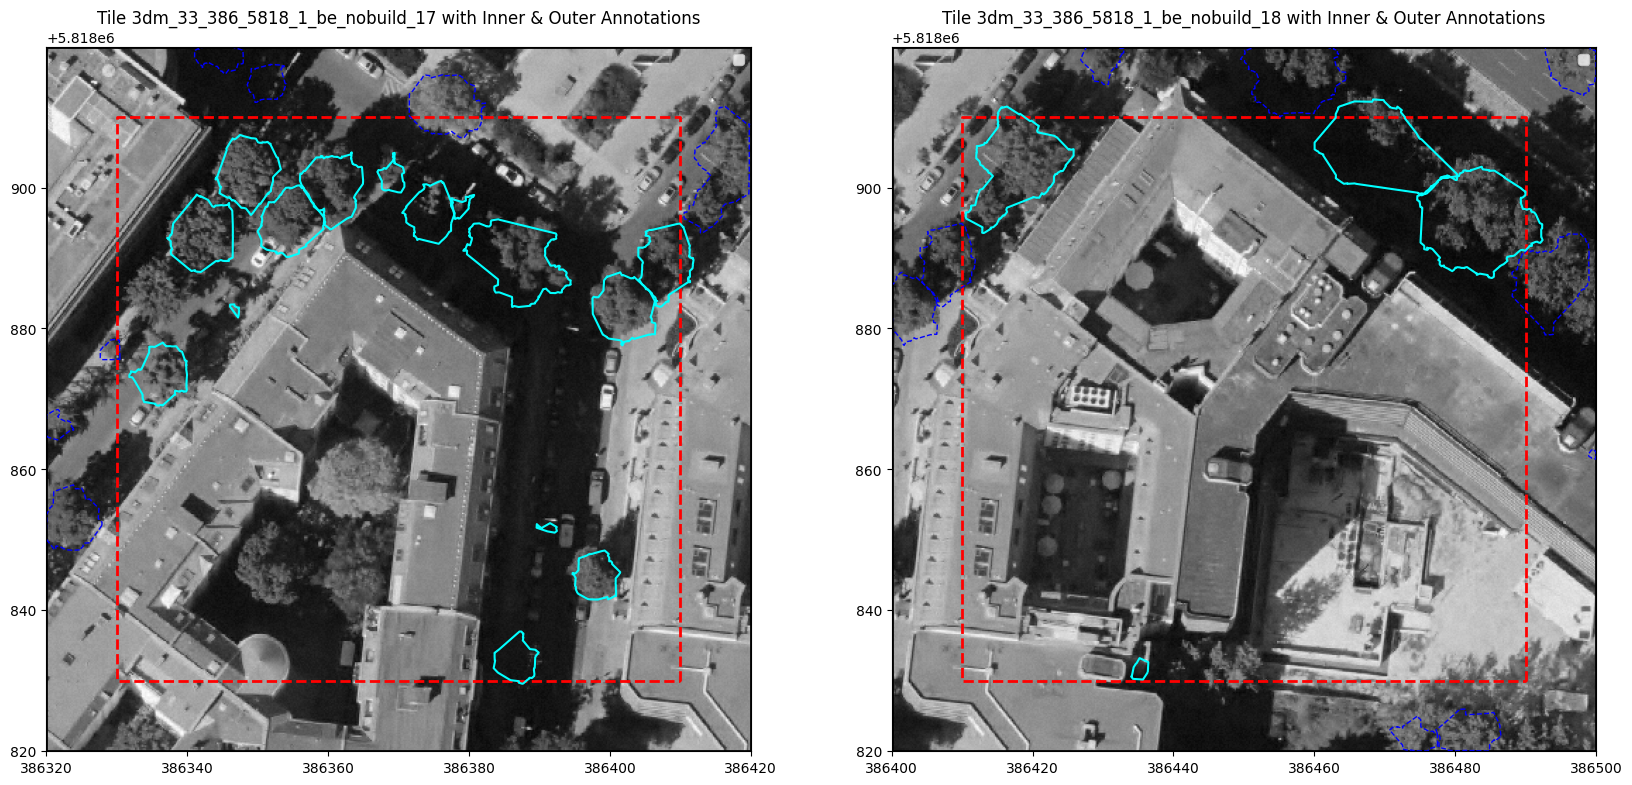

In [33]:
# Select two neighboring tiles for visualization
example_tile_1 = tiles_gdf.index[17]  # First neighboring tile
example_tile_2 = tiles_gdf.index[18]  # Second neighboring tile

# Load tile bounding boxes (original tiles)
tile_geom_1 = tiles_gdf.loc[example_tile_1].geometry
tile_geom_2 = tiles_gdf.loc[example_tile_2].geometry

minx1, miny1, maxx1, maxy1 = tile_geom_1.bounds
minx2, miny2, maxx2, maxy2 = tile_geom_2.bounds

# **Check for neighbors using spatial intersection**
has_top_1, has_bottom_1, has_left_1, has_right_1 = has_spatial_neighbor(tiles_gdf, tile_geom_1)
has_top_2, has_bottom_2, has_left_2, has_right_2 = has_spatial_neighbor(tiles_gdf, tile_geom_2)

# **Apply correct 20m margin for cropping**
margin_m = 10  # Ensure consistency with previous processing

x_inner_min_1 = minx1 + (margin_m if has_left_1 else 0)
y_inner_min_1 = miny1 + (margin_m if has_bottom_1 else 0)
x_inner_max_1 = maxx1 - (margin_m if has_right_1 else 0)
y_inner_max_1 = maxy1 - (margin_m if has_top_1 else 0)
inner_geom_1 = box(x_inner_min_1, y_inner_min_1, x_inner_max_1, y_inner_max_1)

x_inner_min_2 = minx2 + (margin_m if has_left_2 else 0)
y_inner_min_2 = miny2 + (margin_m if has_bottom_2 else 0)
x_inner_max_2 = maxx2 - (margin_m if has_right_2 else 0)
y_inner_max_2 = maxy2 - (margin_m if has_top_2 else 0)
inner_geom_2 = box(x_inner_min_2, y_inner_min_2, x_inner_max_2, y_inner_max_2)

# Define paths
image_path_1 = os.path.join(image_dir, f"{example_tile_1}.tif")
image_path_2 = os.path.join(image_dir, f"{example_tile_2}.tif")
annotation_path_1 = os.path.join(annotations_dir, f"{example_tile_1}.geojson")
annotation_path_2 = os.path.join(annotations_dir, f"{example_tile_2}.geojson")

# Load images
with rasterio.open(image_path_1) as src1, rasterio.open(image_path_2) as src2:
    image_1 = src1.read(1)
    image_2 = src2.read(1)

# Load annotations
annotations_gdf_1 = gpd.read_file(annotation_path_1)
annotations_gdf_2 = gpd.read_file(annotation_path_2)

# **Filter annotations inside and outside the inner region**
annotations_inner_gdf_1 = annotations_gdf_1[annotations_gdf_1.centroid.within(inner_geom_1)]
annotations_outer_gdf_1 = annotations_gdf_1[~annotations_gdf_1.centroid.within(inner_geom_1)]

annotations_inner_gdf_2 = annotations_gdf_2[annotations_gdf_2.centroid.within(inner_geom_2)]
annotations_outer_gdf_2 = annotations_gdf_2[~annotations_gdf_2.centroid.within(inner_geom_2)]

# **Plot both neighboring tiles with overlays**
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# --- First Tile ---
show(image_1, transform=src1.transform, cmap="gray", ax=axes[0])
gpd.GeoSeries(tile_geom_1).plot(ax=axes[0], edgecolor="black", facecolor="none", linewidth=2, label="Original Tile 1")
gpd.GeoSeries(inner_geom_1).plot(ax=axes[0], edgecolor="red", facecolor="none", linewidth=2, linestyle="dashed", label="Inner Tile 1")
annotations_outer_gdf_1.plot(ax=axes[0], edgecolor="blue", facecolor="none", linewidth=1, linestyle="--", label="Outer Annotations 1")
annotations_inner_gdf_1.plot(ax=axes[0], edgecolor="cyan", facecolor="none", linewidth=1.5, label="Inner Annotations 1")
axes[0].set_title(f"Tile {example_tile_1} with Inner & Outer Annotations")
axes[0].legend()

# --- Second Tile ---
show(image_2, transform=src2.transform, cmap="gray", ax=axes[1])
gpd.GeoSeries(tile_geom_2).plot(ax=axes[1], edgecolor="black", facecolor="none", linewidth=2, label="Original Tile 2")
gpd.GeoSeries(inner_geom_2).plot(ax=axes[1], edgecolor="red", facecolor="none", linewidth=2, linestyle="dashed", label="Inner Tile 2")
annotations_outer_gdf_2.plot(ax=axes[1], edgecolor="blue", facecolor="none", linewidth=1, linestyle="--", label="Outer Annotations 2")
annotations_inner_gdf_2.plot(ax=axes[1], edgecolor="cyan", facecolor="none", linewidth=1.5, label="Inner Annotations 2")
axes[1].set_title(f"Tile {example_tile_2} with Inner & Outer Annotations")
axes[1].legend()

plt.show()


# OPTIONAL
# Masked images

In [34]:
if (useMasking):
  #Define paths to the masked images
  masked_image_path_1 = os.path.join(masked_tiles_dir, f"{example_tile_1}.tif")
  masked_image_path_2 = os.path.join(masked_tiles_dir, f"{example_tile_2}.tif")

  # Load masked images
  with rasterio.open(masked_image_path_1) as src1, rasterio.open(masked_image_path_2) as src2:
      masked_image_1 = src1.read(1)
      masked_image_2 = src2.read(1)

  # **Plot both neighboring masked tiles with overlays**
  fig, axes = plt.subplots(1, 2, figsize=(20, 10))

  # --- First Tile (Masked) ---
  show(masked_image_1, transform=src1.transform, cmap="gray", ax=axes[0])
  gpd.GeoSeries(tile_geom_1).plot(ax=axes[0], edgecolor="black", facecolor="none", linewidth=2, label="Original Tile 1")
  gpd.GeoSeries(inner_geom_1).plot(ax=axes[0], edgecolor="red", facecolor="none", linewidth=2, linestyle="dashed", label="Inner Tile 1")
  annotations_outer_gdf_1.plot(ax=axes[0], edgecolor="blue", facecolor="none", linewidth=1, linestyle="--", label="Outer Annotations 1")
  annotations_inner_gdf_1.plot(ax=axes[0], edgecolor="cyan", facecolor="none", linewidth=1.5, label="Inner Annotations 1")
  axes[0].set_title(f"Masked Tile {example_tile_1} with Inner & Outer Annotations")
  axes[0].legend()

  # --- Second Tile (Masked) ---
  show(masked_image_2, transform=src2.transform, cmap="gray", ax=axes[1])
  gpd.GeoSeries(tile_geom_2).plot(ax=axes[1], edgecolor="black", facecolor="none", linewidth=2, label="Original Tile 2")
  gpd.GeoSeries(inner_geom_2).plot(ax=axes[1], edgecolor="red", facecolor="none", linewidth=2, linestyle="dashed", label="Inner Tile 2")
  annotations_outer_gdf_2.plot(ax=axes[1], edgecolor="blue", facecolor="none", linewidth=1, linestyle="--", label="Outer Annotations 2")
  annotations_inner_gdf_2.plot(ax=axes[1], edgecolor="cyan", facecolor="none", linewidth=1.5, label="Inner Annotations 2")
  axes[1].set_title(f"Masked Tile {example_tile_2} with Inner & Outer Annotations")
  axes[1].legend()

  plt.show()


In [35]:
# Check distances between neighboring tiles
tiles_gdf["centroid"] = tiles_gdf.geometry.centroid
tiles_gdf["neighbor_distance"] = tiles_gdf["centroid"].distance(tiles_gdf["centroid"].shift(-1))

print(tiles_gdf[["neighbor_distance"]].head(10))  # Print distances between neighboring tiles


                                neighbor_distance
tile_name                                        
3dm_33_386_5818_1_be_nobuild_0               80.0
3dm_33_386_5818_1_be_nobuild_1               80.0
3dm_33_386_5818_1_be_nobuild_2               80.0
3dm_33_386_5818_1_be_nobuild_3               80.0
3dm_33_386_5818_1_be_nobuild_4               80.0
3dm_33_386_5818_1_be_nobuild_5               80.0
3dm_33_386_5818_1_be_nobuild_6               80.0
3dm_33_386_5818_1_be_nobuild_7               80.0
3dm_33_386_5818_1_be_nobuild_8               80.0
3dm_33_386_5818_1_be_nobuild_9               80.0


# process annotations for inner tile
Crops and converts polygon annotations from GeoJSON to YOLO instance segmentation format.


In [36]:
import geopandas as gpd
import numpy as np
import os
from shapely.geometry import box, Polygon

def process_annotations_for_inner_tile(tile_name, annotation_path, output_txt_path, tiles_gdf, margin_m=10):
    """
    Crops and converts polygon annotations from GeoJSON to YOLO instance segmentation format.

    Args:
        tile_name (str): Tile name.
        annotation_path (str): Path to original annotation file (GeoJSON).
        output_txt_path (str): Path to save YOLO annotation file (.txt).
        tiles_gdf (GeoDataFrame): Tile bounding boxes.
        margin_m (int): Overlap to remove in meters.
    """
    gdf = gpd.read_file(annotation_path)

    # **Get inner bounding box**
    tile_geom = tiles_gdf.loc[tile_name].geometry
    minx, miny, maxx, maxy = tile_geom.bounds

    # **Check for neighbors using spatial intersection**
    has_top, has_bottom, has_left, has_right = has_spatial_neighbor(tiles_gdf, tile_geom)

    # **Apply the correct margin based on neighbor detection**
    x_inner_min = minx + (margin_m if has_left else 0)
    y_inner_min = miny + (margin_m if has_bottom else 0)
    x_inner_max = maxx - (margin_m if has_right else 0)
    y_inner_max = maxy - (margin_m if has_top else 0)

    # **Create a box for the cropped inner tile**
    inner_bbox = box(x_inner_min, y_inner_min, x_inner_max, y_inner_max)

    # **Crop polygons to the inner tile instead of just filtering by centroid**
    gdf["geometry"] = gdf.geometry.intersection(inner_bbox)

    # **Remove empty geometries (fully outside the cropped region)**
    gdf = gdf[gdf.geometry.is_valid & ~gdf.geometry.is_empty]

    # **Convert to YOLO instance segmentation format**
    with open(output_txt_path, "w") as f:
        for _, row in gdf.iterrows():
            if isinstance(row.geometry, Polygon):
                polygon = np.array(row.geometry.exterior.coords)
                class_id = int(row["intersects_cadaster"])

                # Normalize polygon coordinates and clip to [0,1]
                flipped_normalized_polygon = [
                    (
                        max(0.0, min(1.0, (x - x_inner_min) / (x_inner_max - x_inner_min))),  # Clip X
                        max(0.0, min(1.0, 1 - (y - y_inner_min) / (y_inner_max - y_inner_min)))  # Clip Y & Flip
                    )
                    for x, y in polygon
                ]

                # Ensure polygon is closed (add first point to the end)
                flipped_normalized_polygon.append(flipped_normalized_polygon[0])

                # Flatten coordinates for YOLO format
                pts = " ".join(f"{x:.6f} {y:.6f}" for x, y in flipped_normalized_polygon)
                f.write(f"{class_id} {pts}\n")

    print(f"✅ Saved YOLO segmentation annotation (cropped correctly): {output_txt_path}")


In [37]:
for tile_name in tiles_gdf.index:
    image_path = os.path.join(image_dir, f"{tile_name}.tif")
    annotation_path = os.path.join(annotations_dir, f"{tile_name}.geojson")
    output_image_path = os.path.join(output_image_dir, f"{tile_name}_inner.tif")
    output_annotation_path = os.path.join(output_annotation_dir, f"{tile_name}_inner.txt")
    print(image_path)
    if os.path.exists(annotation_path):
        process_annotations_for_inner_tile(tile_name, annotation_path, output_annotation_path, tiles_gdf)


/content/drive/MyDrive/masterthesis/data/386_5818/sliced_imgs_2020S/3dm_33_386_5818_1_be_nobuild_0.tif
✅ Saved YOLO segmentation annotation (cropped correctly): /content/drive/MyDrive/masterthesis/data/386_5818/inner_annotations/3dm_33_386_5818_1_be_nobuild_0_inner.txt
/content/drive/MyDrive/masterthesis/data/386_5818/sliced_imgs_2020S/3dm_33_386_5818_1_be_nobuild_1.tif
✅ Saved YOLO segmentation annotation (cropped correctly): /content/drive/MyDrive/masterthesis/data/386_5818/inner_annotations/3dm_33_386_5818_1_be_nobuild_1_inner.txt
/content/drive/MyDrive/masterthesis/data/386_5818/sliced_imgs_2020S/3dm_33_386_5818_1_be_nobuild_2.tif
✅ Saved YOLO segmentation annotation (cropped correctly): /content/drive/MyDrive/masterthesis/data/386_5818/inner_annotations/3dm_33_386_5818_1_be_nobuild_2_inner.txt
/content/drive/MyDrive/masterthesis/data/386_5818/sliced_imgs_2020S/3dm_33_386_5818_1_be_nobuild_3.tif
✅ Saved YOLO segmentation annotation (cropped correctly): /content/drive/MyDrive/master

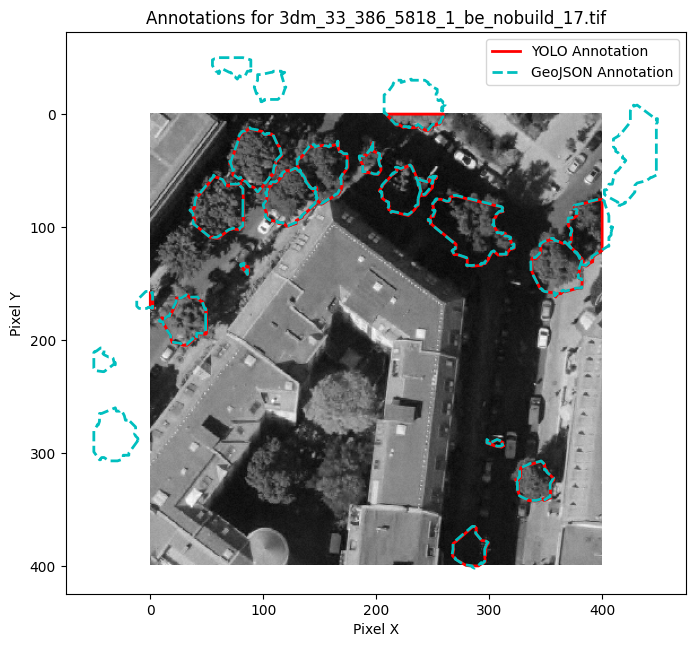

In [38]:
# Define file paths for the selected image and annotations
image_path = "/content/drive/MyDrive/masterthesis/data/386_5818/inner_tiles/3dm_33_386_5818_1_be_nobuild_17.tif"
label_path = "/content/drive/MyDrive/masterthesis/data/386_5818/inner_annotations/3dm_33_386_5818_1_be_nobuild_17_inner.txt"
geojson_path = "/content/drive/MyDrive/masterthesis/data/386_5818/crowns_clean/3dm_33_386_5818_1_be_nobuild_17.geojson"

# Function to plot the image with YOLO and GeoJSON annotations
def plot_annotations(image_path, label_path, geojson_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)
        height, width = image.shape

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(image, cmap="gray", origin="upper")

        # Plot YOLO annotations (Red)
        if os.path.exists(label_path):
            first = True
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    coords = np.array(parts[1:], dtype=float).reshape(-1, 2)

                    # **Scale to pixel values (NO FLIPPING NEEDED)**
                    coords[:, 0] *= width  # Scale X
                    coords[:, 1] *= height  # Just scale, no flipping

                    coords = np.vstack([coords, coords[0]])  # Close the polygon
                    label = "YOLO Annotation" if first else None
                    ax.plot(coords[:, 0], coords[:, 1], "r-", linewidth=2, label=label)
                    first = False

        # Plot GeoJSON annotations (Cyan, Dashed)
        if os.path.exists(geojson_path):
            gdf = gpd.read_file(geojson_path)
            first = True
            for geom in gdf.geometry:
                if geom.geom_type == "Polygon":
                    coords = list(geom.exterior.coords)
                    pixels = np.array([[col, row] for row, col in (src.index(x, y) for x, y in coords)])
                    label = "GeoJSON Annotation" if first else None
                    ax.plot(pixels[:, 0], pixels[:, 1], "c--", linewidth=2, label=label)
                    first = False

        ax.set_xlabel("Pixel X")
        ax.set_ylabel("Pixel Y")
        ax.set_title(f"Annotations for {os.path.basename(image_path)}")
        ax.legend()
        plt.show()

# Plot the selected image and annotations
plot_annotations(image_path, label_path, geojson_path)


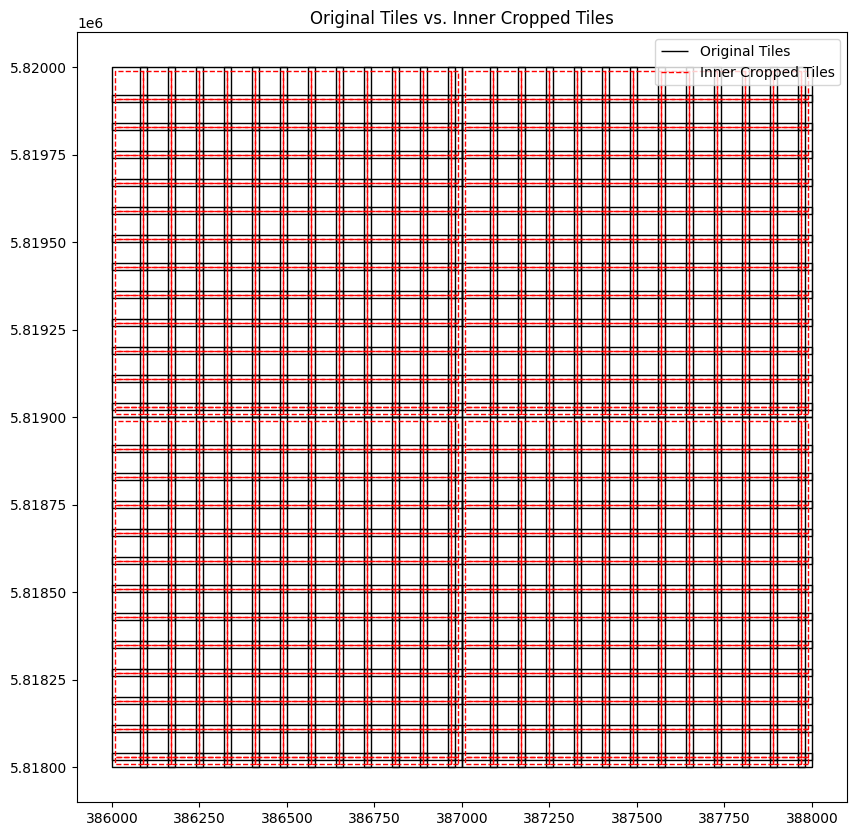

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot all original tiles (black)
tiles_gdf.boundary.plot(ax=ax, color="black", linewidth=1, label="Original Tiles")

# Plot all inner cropped tiles (red)
inner_tiles = tiles_gdf.copy()
inner_tiles["geometry"] = inner_tiles.geometry.buffer(-10)  # Simulating inner cropped tiles
inner_tiles.boundary.plot(ax=ax, color="red", linewidth=1, linestyle="dashed", label="Inner Cropped Tiles")

ax.set_title("Original Tiles vs. Inner Cropped Tiles")
ax.legend()
plt.show()


In [40]:
tiles_gdf["cropped_width"] = tiles_gdf.geometry.bounds.maxx - tiles_gdf.geometry.bounds.minx - 2 * 20
tiles_gdf["cropped_height"] = tiles_gdf.geometry.bounds.maxy - tiles_gdf.geometry.bounds.miny - 2 * 20

print(tiles_gdf[["cropped_width", "cropped_height"]].head(10))


                                cropped_width  cropped_height
tile_name                                                    
3dm_33_386_5818_1_be_nobuild_0           60.0            60.0
3dm_33_386_5818_1_be_nobuild_1           60.0            60.0
3dm_33_386_5818_1_be_nobuild_2           60.0            60.0
3dm_33_386_5818_1_be_nobuild_3           60.0            60.0
3dm_33_386_5818_1_be_nobuild_4           60.0            60.0
3dm_33_386_5818_1_be_nobuild_5           60.0            60.0
3dm_33_386_5818_1_be_nobuild_6           60.0            60.0
3dm_33_386_5818_1_be_nobuild_7           60.0            60.0
3dm_33_386_5818_1_be_nobuild_8           60.0            60.0
3dm_33_386_5818_1_be_nobuild_9           60.0            60.0
